In [1]:
import logging
logging.basicConfig(level=logging.CRITICAL)

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocess as mp

from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler

from cooltools.lib.numutils import adaptive_coarsegrain, get_eig
from cooltools.lib.plotting import *

from mpl_toolkits import axes_grid1

import hoomd
from polykit.analysis import contact_maps, polymer_analyses
import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic
import os,subprocess             

In [2]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [3]:
matrix_path = "../../agalicina/coolers/Unsynchronized_Auxin360mins.hg38.mapq_30.1000.mcool"
genome_path = '../../genomes/hg38.fa'

hg38_genome = bioframe.load_fasta(genome_path)
clr = cooler.Cooler(matrix_path+'::resolutions/100000')

In [4]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
bins = clr.bins()[:]
#gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
#gc_cov.to_csv('hg38_gc_cov_100kb.tsv',index=False,sep='\t')
gc_cov=pd.read_csv('hg38_gc_cov_100kb.tsv', sep='\t')
gc_cov.head()

,chrom,start,end,GC
0,chr1,0,100000,0.424522
1,chr1,100000,200000,0.458150
2,chr1,200000,300000,0.405687
3,chr1,300000,400000,0.471883
4,chr1,400000,500000,0.401920


In [133]:
hg38_chromsizes

name
chr1     248956422
chr2     242193529
chr3     198295559
chr4     190214555
chr5     181538259
chr6     170805979
chr7     159345973
chr8     145138636
chr9     138394717
chr10    133797422
chr11    135086622
chr12    133275309
chr13    114364328
chr14    107043718
chr15    101991189
chr16     90338345
chr17     83257441
chr18     80373285
chr19     58617616
chr20     64444167
chr21     46709983
chr22     50818468
chrX     156040895
chrY      57227415
chrM         16569
Name: length, dtype: int64

In [5]:
#chr9: 107.5–110.5 Mb
view_df = pd.DataFrame({'chrom': "chr2",
                        'start': [3000000],
                        'end': [53000000],
                        'name': "chr2"}
                      )
view_df

,chrom,start,end,name
0,chr2,3000000,53000000,chr2


In [6]:
import logging, matplotlib
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## some plotting stuff
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'fall'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [7]:
id1, id2 = clr.extent('chr2')
length = 500
inds = np.arange(id1, id1+length)

(0.0, 500.0)

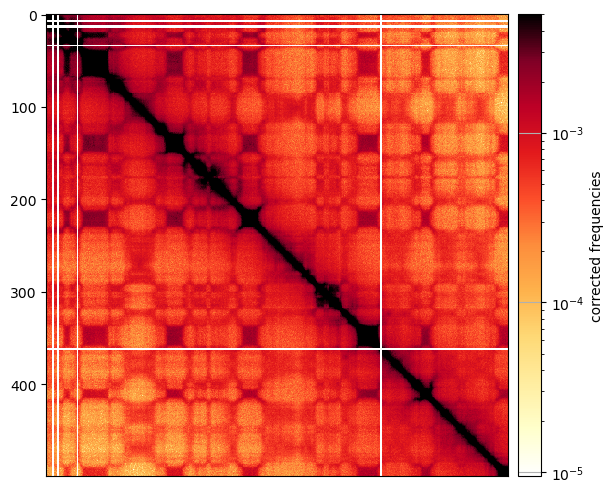

In [8]:
f, axs = plt.subplots(
    figsize=(9, 6),
    ncols=1, nrows=1
)

norm = LogNorm(vmax=0.005)

ax = axs#[0]
im = ax.matshow(
    clr.matrix()[:][np.ix_(inds,inds)], 
    norm=norm,  
    cmap='fall'
); 
plt.grid(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.xaxis.set_visible(False)

ax.set_xlim([0, len(inds)])

In [9]:
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
binned_track= eigenvector_track.copy()
binned_track['E1'] = binned_track['E1'].apply(lambda x: 'B' if pd.isna(x) or x < 0 else 'A')
binned_track.replace({'A': 0, 'B': 1},inplace=True)
motif = np.array(binned_track['E1'].repeat(40))

In [10]:
motif

array([1, 1, 1, ..., 0, 0, 0])

In [134]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [135]:
# Read input force parameters
with open("./examples/force_dict_heteropolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "Harmonic"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.1
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 3.0,
                    "B": 3.0
                },
                "B": {
                    "A": 3.0,
                    "B": 3.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [136]:
hoomd_device = hoomd.device.GPU(notice_level=3,gpu_ids=[2])

In [137]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 45971


In [138]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [139]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
n_repl=10
density = 0.2
chromosome_sizes = [20000*n_repl]

In [140]:
# Initialize simulation with the appropriate box size 
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density) ** (1/3.)

snapshot = build.get_simulation_box(box_length=L)

In [141]:
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-1))

In [142]:
build.set_chains(snapshot, monomer_positions, chromosome_sizes)

In [143]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [144]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

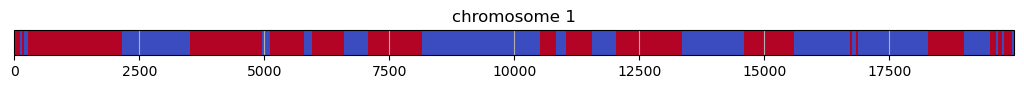

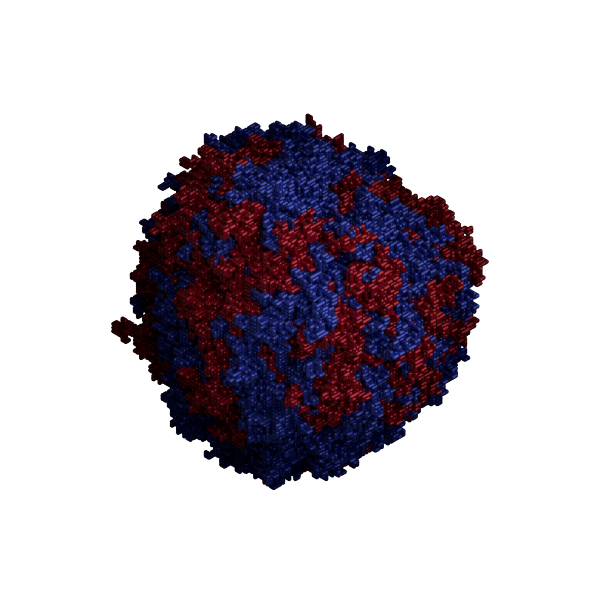

In [145]:
# Assign and visualize domains in 1D/3D
snapshot.particles.typeid[:] = np.tile(motif,n_repl)
render.domain_viewer(snapshot, cmap="coolwarm")
render.fresnel(snapshot, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [146]:
# Load updated snapshot
system.create_state_from_snapshot(snapshot)

In [147]:
# Set a pseudo square well attraction force acting on B-type monomers
force_dict["Non-bonded forces"]["Attraction"] = {
    "Cutoff": 1.5,
    "Matrix": {
        "A": {
            "A": 0,
            "B": 0
        },
        "B": {
            "A": 0,
            "B": 0.05
        }
    },
    "Type": "Polychrom"
}

In [148]:
# Update force field, including a DPD thermostat
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

force_field = repulsion_forces + bonded_forces + angular_forces+attraction_forces + dpd_forces

Setting up DPD with the conservative force contribution disabled


In [149]:
# Setup new DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home/fabianpa/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [150]:
logger = log.get_logger(system)
system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

In [151]:
out_file = 'trajectory_1.gsd'
gsd_writer = hoomd.write.GSD(filename=out_file,
                             trigger=hoomd.trigger.Periodic(1000),
                             dynamic=['topology'],
                             mode='wb')

system.operations.writers.append(gsd_writer)

In [ ]:
# Run
system.run(1e6)

notice(3): GSD: create or overwrite gsd file trajectory_1.gsd
Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           560.67585      0:29:25.726139           1.02407          
       20000           645.76486      0:25:17.580252           1.03004          
       30000           703.28295      0:22:59.245713           1.01797          
       40000           734.93596      0:21:46.236256           1.00851          
       50000           732.68480      0:21:36.601208           1.00592          
       60000           745.41910      0:21:01.035576           1.00844          
       70000           759.03850      0:20:25.234285           1.00705          
       80000           769.63560      0:19:55.370896           1.00380          
       90000           773.64596      0:19:36.248635           1.00221          
      100000           769.98360      0:19:28.856062           1.00569          
      110000           776.80238      0:19:05.7

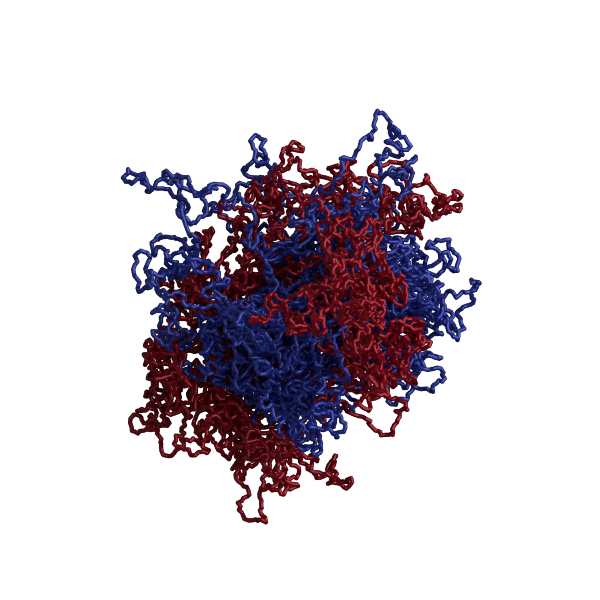

In [118]:
snapshot_collapsed = system.state.get_snapshot()
render.fresnel(snapshot_collapsed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [128]:
from polykit.analysis import contact_maps
import gsd

def load_gsd(filename):
    fname, group = filename.split("::")

    with gsd.hoomd.open(name=fname, mode="rb") as traj:
        return traj[int(group)].particles.position

skip = 100
trajectory = gsd.hoomd.open(name=out_file, mode="r")

URIs = [out_file + "::%d" % i for i in range(skip, len(list(trajectory)), 1)]

['trajectory.gsd::100',
 'trajectory.gsd::101',
 'trajectory.gsd::102',
 'trajectory.gsd::103',
 'trajectory.gsd::104',
 'trajectory.gsd::105',
 'trajectory.gsd::106',
 'trajectory.gsd::107',
 'trajectory.gsd::108',
 'trajectory.gsd::109',
 'trajectory.gsd::110',
 'trajectory.gsd::111',
 'trajectory.gsd::112',
 'trajectory.gsd::113',
 'trajectory.gsd::114',
 'trajectory.gsd::115',
 'trajectory.gsd::116',
 'trajectory.gsd::117',
 'trajectory.gsd::118',
 'trajectory.gsd::119',
 'trajectory.gsd::120',
 'trajectory.gsd::121',
 'trajectory.gsd::122',
 'trajectory.gsd::123',
 'trajectory.gsd::124',
 'trajectory.gsd::125',
 'trajectory.gsd::126',
 'trajectory.gsd::127',
 'trajectory.gsd::128',
 'trajectory.gsd::129',
 'trajectory.gsd::130',
 'trajectory.gsd::131',
 'trajectory.gsd::132',
 'trajectory.gsd::133',
 'trajectory.gsd::134',
 'trajectory.gsd::135',
 'trajectory.gsd::136',
 'trajectory.gsd::137',
 'trajectory.gsd::138',
 'trajectory.gsd::139',
 'trajectory.gsd::140',
 'trajectory.gsd

In [129]:
start = np.arange(n_repl) *20000
matrix = contact_maps.monomerResolutionContactMapSubchains(
                URIs,
                load_gsd,
                start,
                20000,
                cutoff=2.3,
                n=4)

/home/fabianpa/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
/home/fabianpa/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
/home/fabianpa/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
/home/fabianpa/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [132]:
clr = contact_maps.coolify(matrix, 'single_conformation')

# Compute contact map
#matrix = np.zeros((snapshot_collapsed.particles.N, snapshot_collapsed.particles.N))
#contacts = polymer_analyses.calculate_contacts(snapshot_collapsed.particles.position, cutoff=5)

#for x, y in contacts:
#    matrix[x, y] += 1
#    matrix[y, x] += 1

/tmp/ipykernel_2028519/3388863557.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap("hot")


Text(0.5, 1.0, 'Contact map of a single conformation')

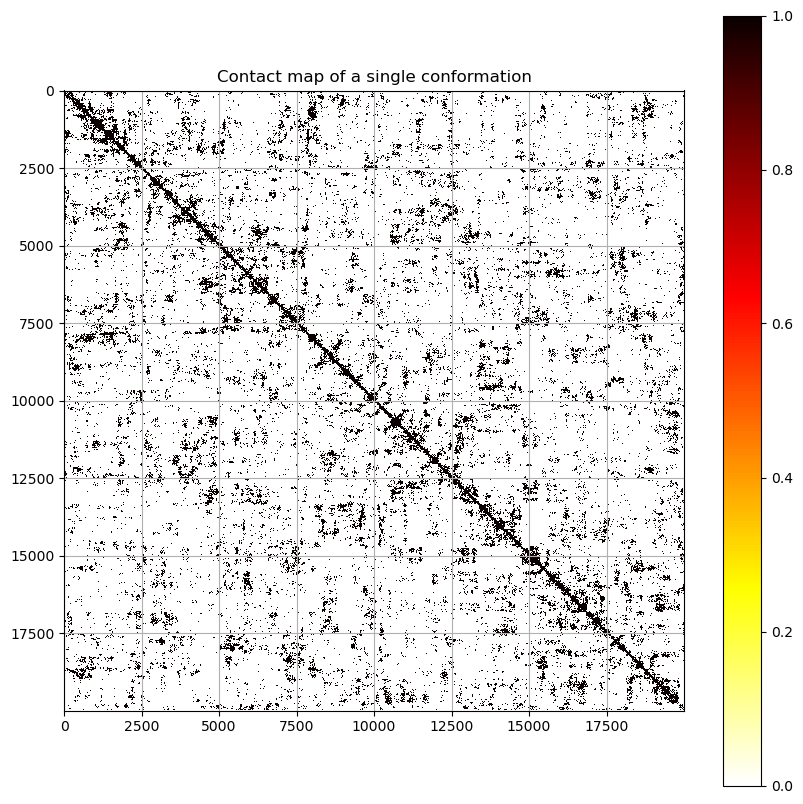

In [130]:
orig_map=plt.cm.get_cmap("hot") 
reversed_map = orig_map.reversed() 

plt.figure(figsize=(10,10))

plt.imshow(matrix, vmax=1, interpolation="none", cmap=reversed_map)

plt.colorbar()
plt.title('Contact map of a single conformation')